In [1]:
import matplotlib.pyplot as plt
import itertools


def calculate_two_peaks_probability(visual_peaks_values):
    combinations = list(
        itertools.chain.from_iterable(
            itertools.combinations(visual_peaks_values, i + 2)
            for i in range(len(visual_peaks_values))
        )
    )

    probs_array = np.array([])

    for i in combinations:
        probs_array = np.append(probs_array, np.array(i).prod())

    return probs_array.sum() / probs_array.size

In [23]:
from scipy.optimize import curve_fit


def sig(x, a, b, c, d):
    """Compute sigmoidal value for the given delay.
    Args:
        x (1D np.array): Delay (ms).
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).

    Returns:
        sig (1D np.array): Vector with values for the given delay points.
    """
    return a + b / (1 + np.exp(-(x - c) / d))


def sigfit(x, y):
    """Fit the RT data to a sigmoidal function.

    Args:
        x (1D np.array): Delay (ms).
        y (1D np.array) : Values for the given delay points.

    Returns:
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).
    """

    # Obtains the upper and lower bounds
    a = np.min(y)
    b = np.max(y)

    # Defines starting points and boundaries for the fitting
    k_0 = (a - b) / (x[-1] - x[0])
    initial_slope = -(a - b) / (4 * k_0)
    # if initial_slope>=0: initial_slope=-0.0001
    middle_x = np.max(x) / 2
    init_guess = [a, b, middle_x, initial_slope]
    boundaries = ([0, 0, np.min(x), float("-inf")], [100, 100, np.max(x), 0])

    # Fits the data
    popt, _ = curve_fit(
        sig,
        x,
        y,
        p0=init_guess,
        method="trf",
        ftol=1e-8,
        xtol=1e-8,
        maxfev=100000,
        bounds=boundaries,
    )
    sigpar = np.asarray(popt)
    a = sigpar[0]
    b = sigpar[1]
    c = sigpar[2]
    d = sigpar[3]

    return a, b, c, d

In [94]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100
data.rename(columns={"Flashes": "Flashes (%)", "Delay": "SOA"}, inplace=True)
data["SOA"] = data.SOA.astype(float)

# Average data by group
avg_data = data.groupby(["Group", "SOA"])["Flashes (%)"].aggregate(["mean", "sem"])
avg_data.reset_index(inplace=True)
avg_data.rename(
    columns={"mean": "Flashes (%)", "sem": "Flashes (%) - sem"}, inplace=True
)
avg_data.sort_values("SOA", inplace=True)

soas = avg_data.SOA.unique()

In [95]:
hspq_raw_data = avg_data.query("Group == 'H-SPQ' ")["Flashes (%)"].values
lspq_raw_data = avg_data.query("Group == 'L-SPQ' ")["Flashes (%)"].values

hspq_a, hspq_b, hspq_c, hspq_d = sigfit(soas, hspq_raw_data)
lspq_a, lspq_b, lspq_c, lspq_d = sigfit(soas, lspq_raw_data)

print("H-SPQ:", hspq_a, hspq_b, hspq_c, hspq_d)
print("L-SPQ:", lspq_a, lspq_b, lspq_c, lspq_d)

H-SPQ: 13.054102931589933 65.54003383492073 85.57700594416406 -30.097780765674145
L-SPQ: 15.045055189031906 66.7103710786294 59.806104095255904 -26.55312519356362


In [99]:
# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(x=group[1]["SOA"], a=hspq_a, b=hspq_b, c=hspq_c, d=hspq_d)
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(x=group[1]["SOA"], a=lspq_a, b=lspq_b, c=lspq_c, d=lspq_d)
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

,Group,SOA,Flashes (%),Flashes (%) - sem,Fit
0,H-SPQ,36.0,68.214286,5.321753,68.010208
1,H-SPQ,48.0,62.857143,6.082700,63.981309
2,H-SPQ,60.0,60.714286,5.514017,58.966507
3,H-SPQ,72.0,52.142857,5.451982,53.092505
4,H-SPQ,84.0,48.571429,5.532833,46.682434


In [6]:
from skneuromsi.neural import Paredes2022
import numpy as np
from findpeaks import findpeaks
from joblib import Parallel, delayed


def myjob_lspq(soa, cm_weight, fb_weight, ff_weight, a_tau, v_tau, m_tau, l_ex):
    model = Paredes2022(
        time_range=(0, 550),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )
    res = model.run(
        auditory_intensity=2.425,
        visual_intensity=1.375,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        soa=soa,
        noise=False,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
        lateral_excitation=l_ex,
    )
    fp = findpeaks(method="topology", verbose=0, limit=0.15)
    fp_results = fp.fit(res.get_modes("visual").query("positions==15").visual.values)
    visual_peaks_df = fp_results["df"].query("peak==True & valley==False")
    if visual_peaks_df["score"].size < 2:
        p_two_flashes = 0
    else:
        p_two_flashes = calculate_two_peaks_probability(visual_peaks_df["y"].values)
    return p_two_flashes


with Parallel(n_jobs=-1) as parallel:
    par_res = parallel(
        delayed(myjob_lspq)(
            soa, 1.327e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02, 1.6
        )
        for soa in soas
    )

two_flashes = par_res
lspq_raw_model_data = np.array(two_flashes) * 100

with Parallel(n_jobs=-1) as parallel:
    par_res = parallel(
        delayed(myjob_lspq)(
            soa, 1.327e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02, 1.632e00
        )
        for soa in soas
    )

two_flashes = par_res
hspq_raw_model_data = np.array(two_flashes) * 100

with Parallel(n_jobs=-1) as parallel:
    par_res = parallel(
        delayed(myjob_lspq)(
            soa, 2.707e-02, 2.423e-01, 2.461e00, 6.712e00, 2.356e01, 1.175e02, 1.6
        )
        for soa in soas
    )

two_flashes = par_res
alter_hspq_raw_model_data = np.array(two_flashes) * 100

In [63]:
model_hspq_a, model_hspq_b, model_hspq_c, model_hspq_d = sigfit(
    soas, hspq_raw_model_data
)
alter_model_hspq_a, alter_model_hspq_b, alter_model_hspq_c, alter_model_hspq_d = sigfit(
    soas, alter_hspq_raw_model_data
)
model_lspq_a, model_lspq_b, model_lspq_c, model_lspq_d = sigfit(
    soas, lspq_raw_model_data
)

data_twi = [
    [
        "L-SPQ",
        "Model",
        model_lspq_c,
    ],
    ["L-SPQ", "Data", lspq_c],
    [
        "H-SPQ",
        "Model",
        model_hspq_c,
    ],
    ["H-SPQ", "Data", hspq_c],
]

df_twi = pd.DataFrame(data=data_twi, columns=["Group", "Data", "TWI (ms)"])
df_twi

,Group,Data,TWI (ms)
0,L-SPQ,Model,71.277086
1,L-SPQ,Data,59.806104
2,H-SPQ,Model,102.536916
3,H-SPQ,Data,85.577006


In [299]:
# Compute TWI individually and get average and sem
df_fit = pd.DataFrame(columns=["Group", "ID", "a", "b", "TWI (ms)", "d"])

for group in data.groupby("Group"):
    for participant in group[1].groupby("ID"):
        a, b, c, d = sigfit(soas, participant[1]["Flashes (%)"])
        df_fit.loc[len(df_fit.index)] = [group[0], participant[0], a, b, c, d]

df_fit.sort_values("Group", ascending=False, inplace=True)

In [41]:
import seaborn as sns

sns.set_context("paper")
sns.set_theme(
    style="ticks",
    palette=["black", "grey", "grey"],
    rc={"axes.labelsize": 12, "axes.labelweight": "bold"},
)

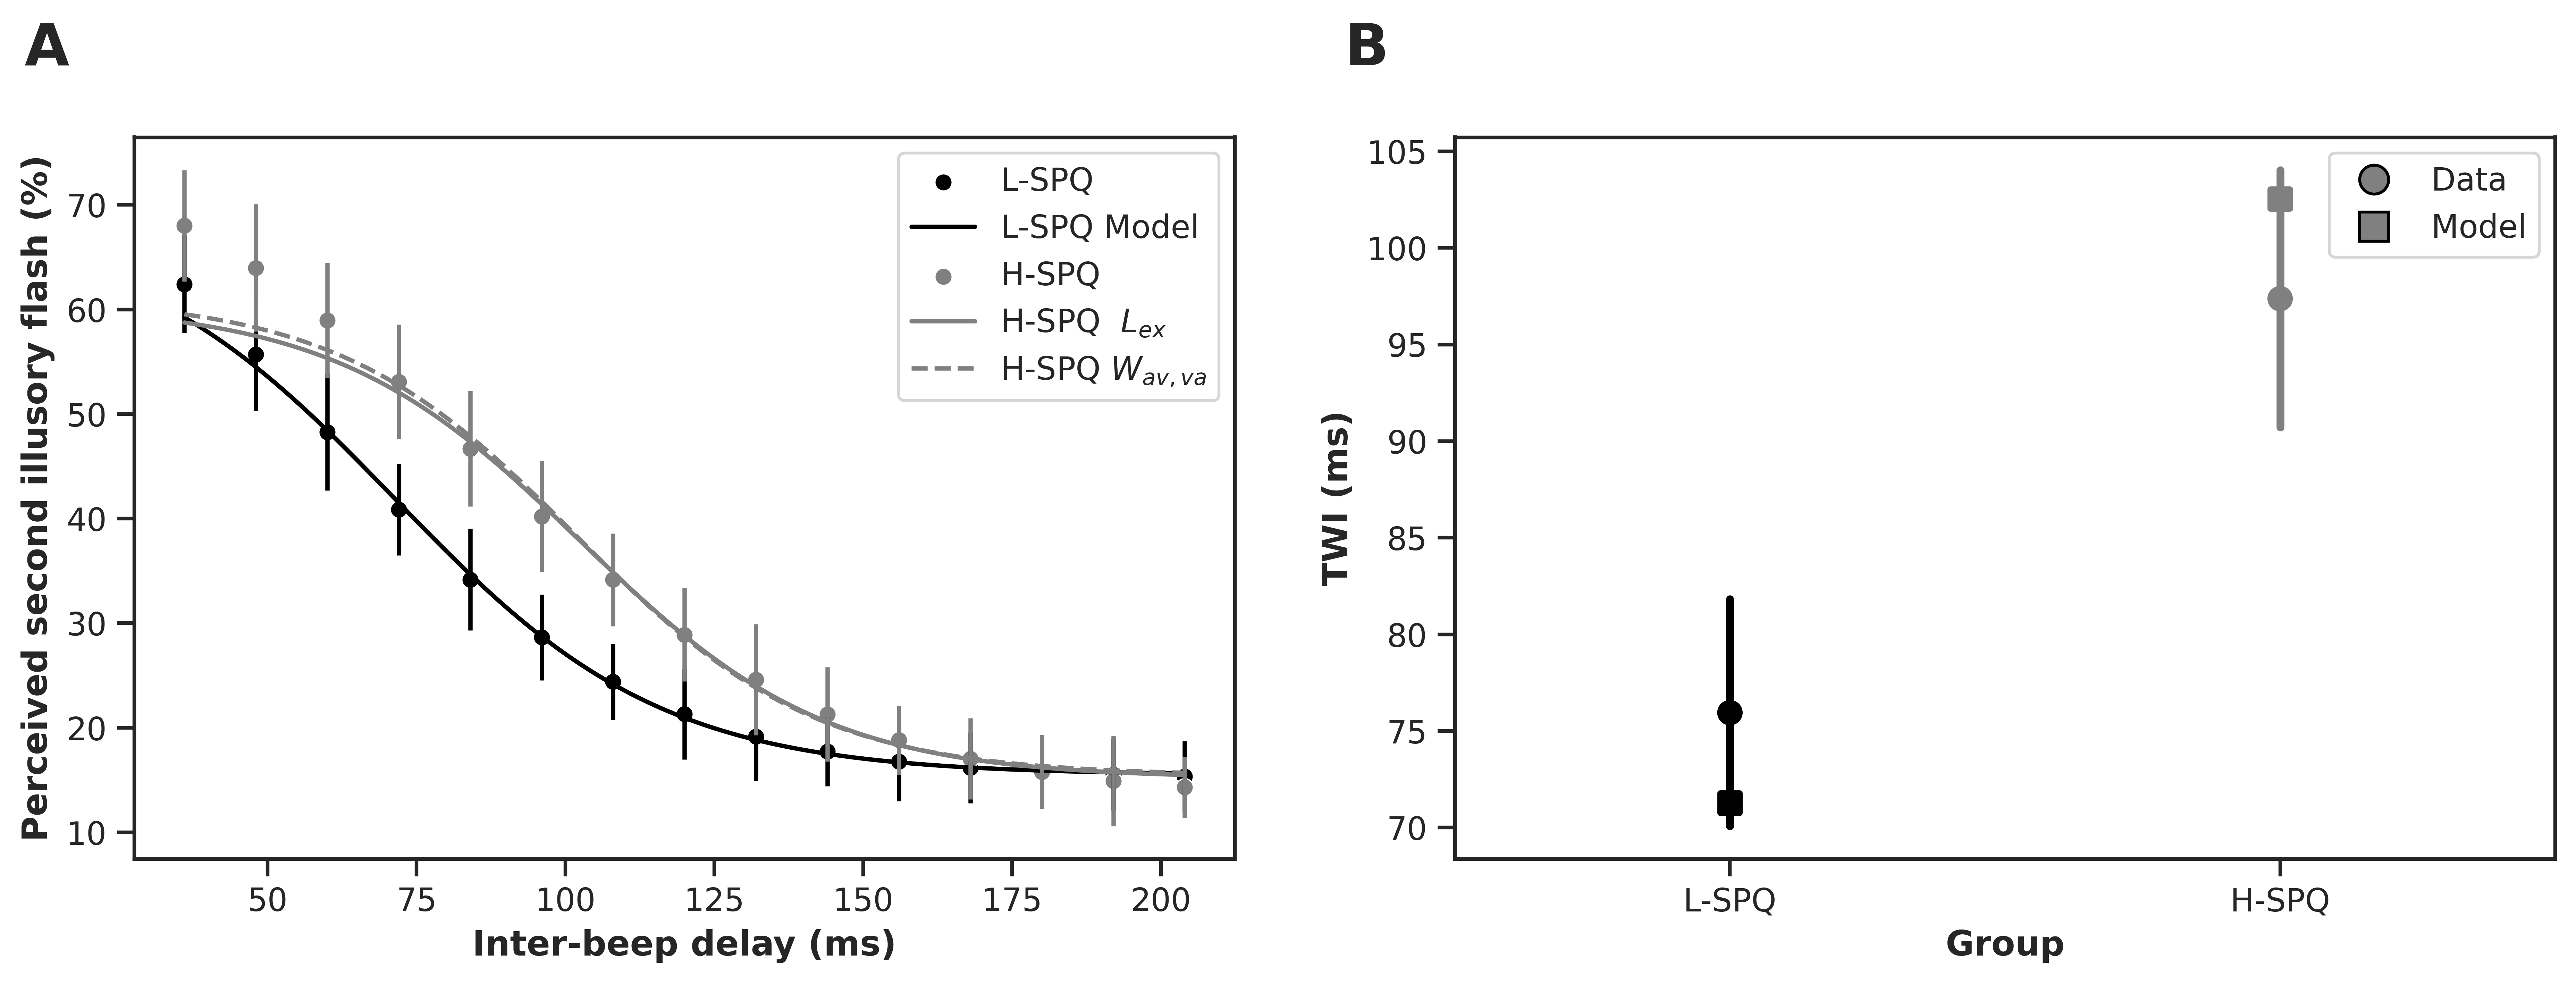

In [334]:
import string
import matplotlib.lines as mlines

model_soas = np.linspace(soas[0], soas[-1], 100)
hspq_model_data = sig(
    model_soas, model_hspq_a, model_hspq_b, model_hspq_c, model_hspq_d
)
alter_hspq_model_data = sig(
    model_soas,
    alter_model_hspq_a,
    alter_model_hspq_b,
    alter_model_hspq_c,
    alter_model_hspq_d,
)
lspq_model_data = sig(
    model_soas, model_lspq_a, model_lspq_b, model_lspq_c, model_lspq_d
)

lspq_data = dataset.query("Group == 'L-SPQ' ").sort_values("SOA").Fit.values
hspq_data = dataset.query("Group == 'H-SPQ' ").sort_values("SOA").Fit.values

lspq_data_err = (
    dataset.query("Group == 'L-SPQ' ").sort_values("SOA")["Flashes (%) - sem"].values
)
hspq_data_err = (
    dataset.query("Group == 'H-SPQ' ").sort_values("SOA")["Flashes (%) - sem"].values
)

fig, axs = plt.subplots(1, 2, figsize=(15, 4.5), dpi=600)
ax1 = plt.subplot(121)

sns.scatterplot(x=soas, y=lspq_data, label="L-SPQ", ax=ax1)
ax1.errorbar(x=soas, y=lspq_data, yerr=lspq_data_err, fmt="none", color="black")
sns.lineplot(x=model_soas, y=lspq_model_data, label="L-SPQ Model", ax=ax1)
sns.scatterplot(x=soas, y=hspq_data, label="H-SPQ", ax=ax1)
ax1.errorbar(x=soas, y=hspq_data, yerr=hspq_data_err, fmt="none", color="gray")
sns.lineplot(x=model_soas, y=hspq_model_data, label="H-SPQ  $L_{ex}$", ax=ax1)
sns.lineplot(
    x=model_soas,
    y=alter_hspq_model_data,
    label="H-SPQ $W_{av,va}$",
    ax=ax1,
    linestyle="--",
)

ax1.set_xlabel("Inter-beep delay (ms)")
ax1.set_ylabel("Perceived second illusory flash (%)")
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax2 = plt.subplot(122)
sns.pointplot(
    x="Group",
    y="TWI (ms)",
    data=df_fit,
    join=False,
    errorbar="se",
    ax=ax2,
    label="Data",
    palette=["black", "gray"],
)
sns.pointplot(
    x=["L-SPQ", "H-SPQ"],
    y=[model_lspq_c, model_hspq_c],
    join=False,
    ax=ax2,
    label="Model",
    markers="s",
    palette=["black", "gray"],
)
ax2.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

circle = mlines.Line2D(
    [],
    [],
    marker="o",
    linestyle="None",
    markersize=10,
    label="Data",
    markerfacecolor="gray",
    markeredgecolor="black",
)
square = mlines.Line2D(
    [],
    [],
    marker="s",
    linestyle="None",
    markersize=10,
    label="Model",
    markerfacecolor="gray",
    markeredgecolor="black",
)
ax2.legend(handles=[circle, square])

fig.savefig("drafts/FIG4.eps", bbox_inches="tight", format="eps")